Name: Reagan Todd (14310596)

Date: Created 2025-12-08

Purpose: to demonstrate mastery of CS-5530.

Copyright: For educational purposes only.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd

# Part 0

In [3]:
import hashlib,  numpy as np, random

STUDENT_ID_STR = "14310596"
# Personal seed derived from hash (stable, unique)
seed = int(hashlib.sha256(STUDENT_ID_STR.encode()).hexdigest(), 16) % (10**9)
rng = np.random.default_rng(seed)
random.seed(seed)
np.random.seed(seed)
# Assigned parameters (unique to each student)
dataset_pick = rng.integers(0, 3) # 0/1/2 choose dataset
cv_folds = int(rng.choice([4,5,6,7,8])) # K for K-fold CV
bootstrap_B = int(rng.choice([400, 600, 800])) # bootstrap replicates
outlier_method = rng.choice(["IQR", "zscore"]) # handling strategy
knn_k = int(rng.choice([3,5,7,9])) # K for KNN
tree_depth = int(rng.choice([3,4,5,6,7])) # max depth for trees
sim_bias_p = float(rng.choice([0.35, 0.45, 0.55, 0.65])) # for simulation
viz_trick = rng.choice(["truncated_y", "unequal_bins", "dual_axis"]) # ethics plot variant
print({
"seed": seed, "dataset_pick": int(dataset_pick), "cv_folds": cv_folds,
"bootstrap_B": bootstrap_B, "outlier_method": outlier_method,
"knn_k": knn_k, "tree_depth": tree_depth, "sim_bias_p": sim_bias_p,
"viz_trick": viz_trick
})

{'seed': 3809056, 'dataset_pick': 0, 'cv_folds': 8, 'bootstrap_B': 800, 'outlier_method': np.str_('zscore'), 'knn_k': 3, 'tree_depth': 6, 'sim_bias_p': 0.65, 'viz_trick': np.str_('truncated_y')}


Dataset: 0, Units not found, will assume mm

Seed: 3809056

# Part A

In [4]:
import sklearn.datasets
df=sklearn.datasets.load_breast_cancer(as_frame=True).frame
print(df.dtypes)
df.head()



mean radius                float64
mean texture               float64
mean perimeter             float64
mean area                  float64
mean smoothness            float64
mean compactness           float64
mean concavity             float64
mean concave points        float64
mean symmetry              float64
mean fractal dimension     float64
radius error               float64
texture error              float64
perimeter error            float64
area error                 float64
smoothness error           float64
compactness error          float64
concavity error            float64
concave points error       float64
symmetry error             float64
fractal dimension error    float64
worst radius               float64
worst texture              float64
worst perimeter            float64
worst area                 float64
worst smoothness           float64
worst compactness          float64
worst concavity            float64
worst concave points       float64
worst symmetry      

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


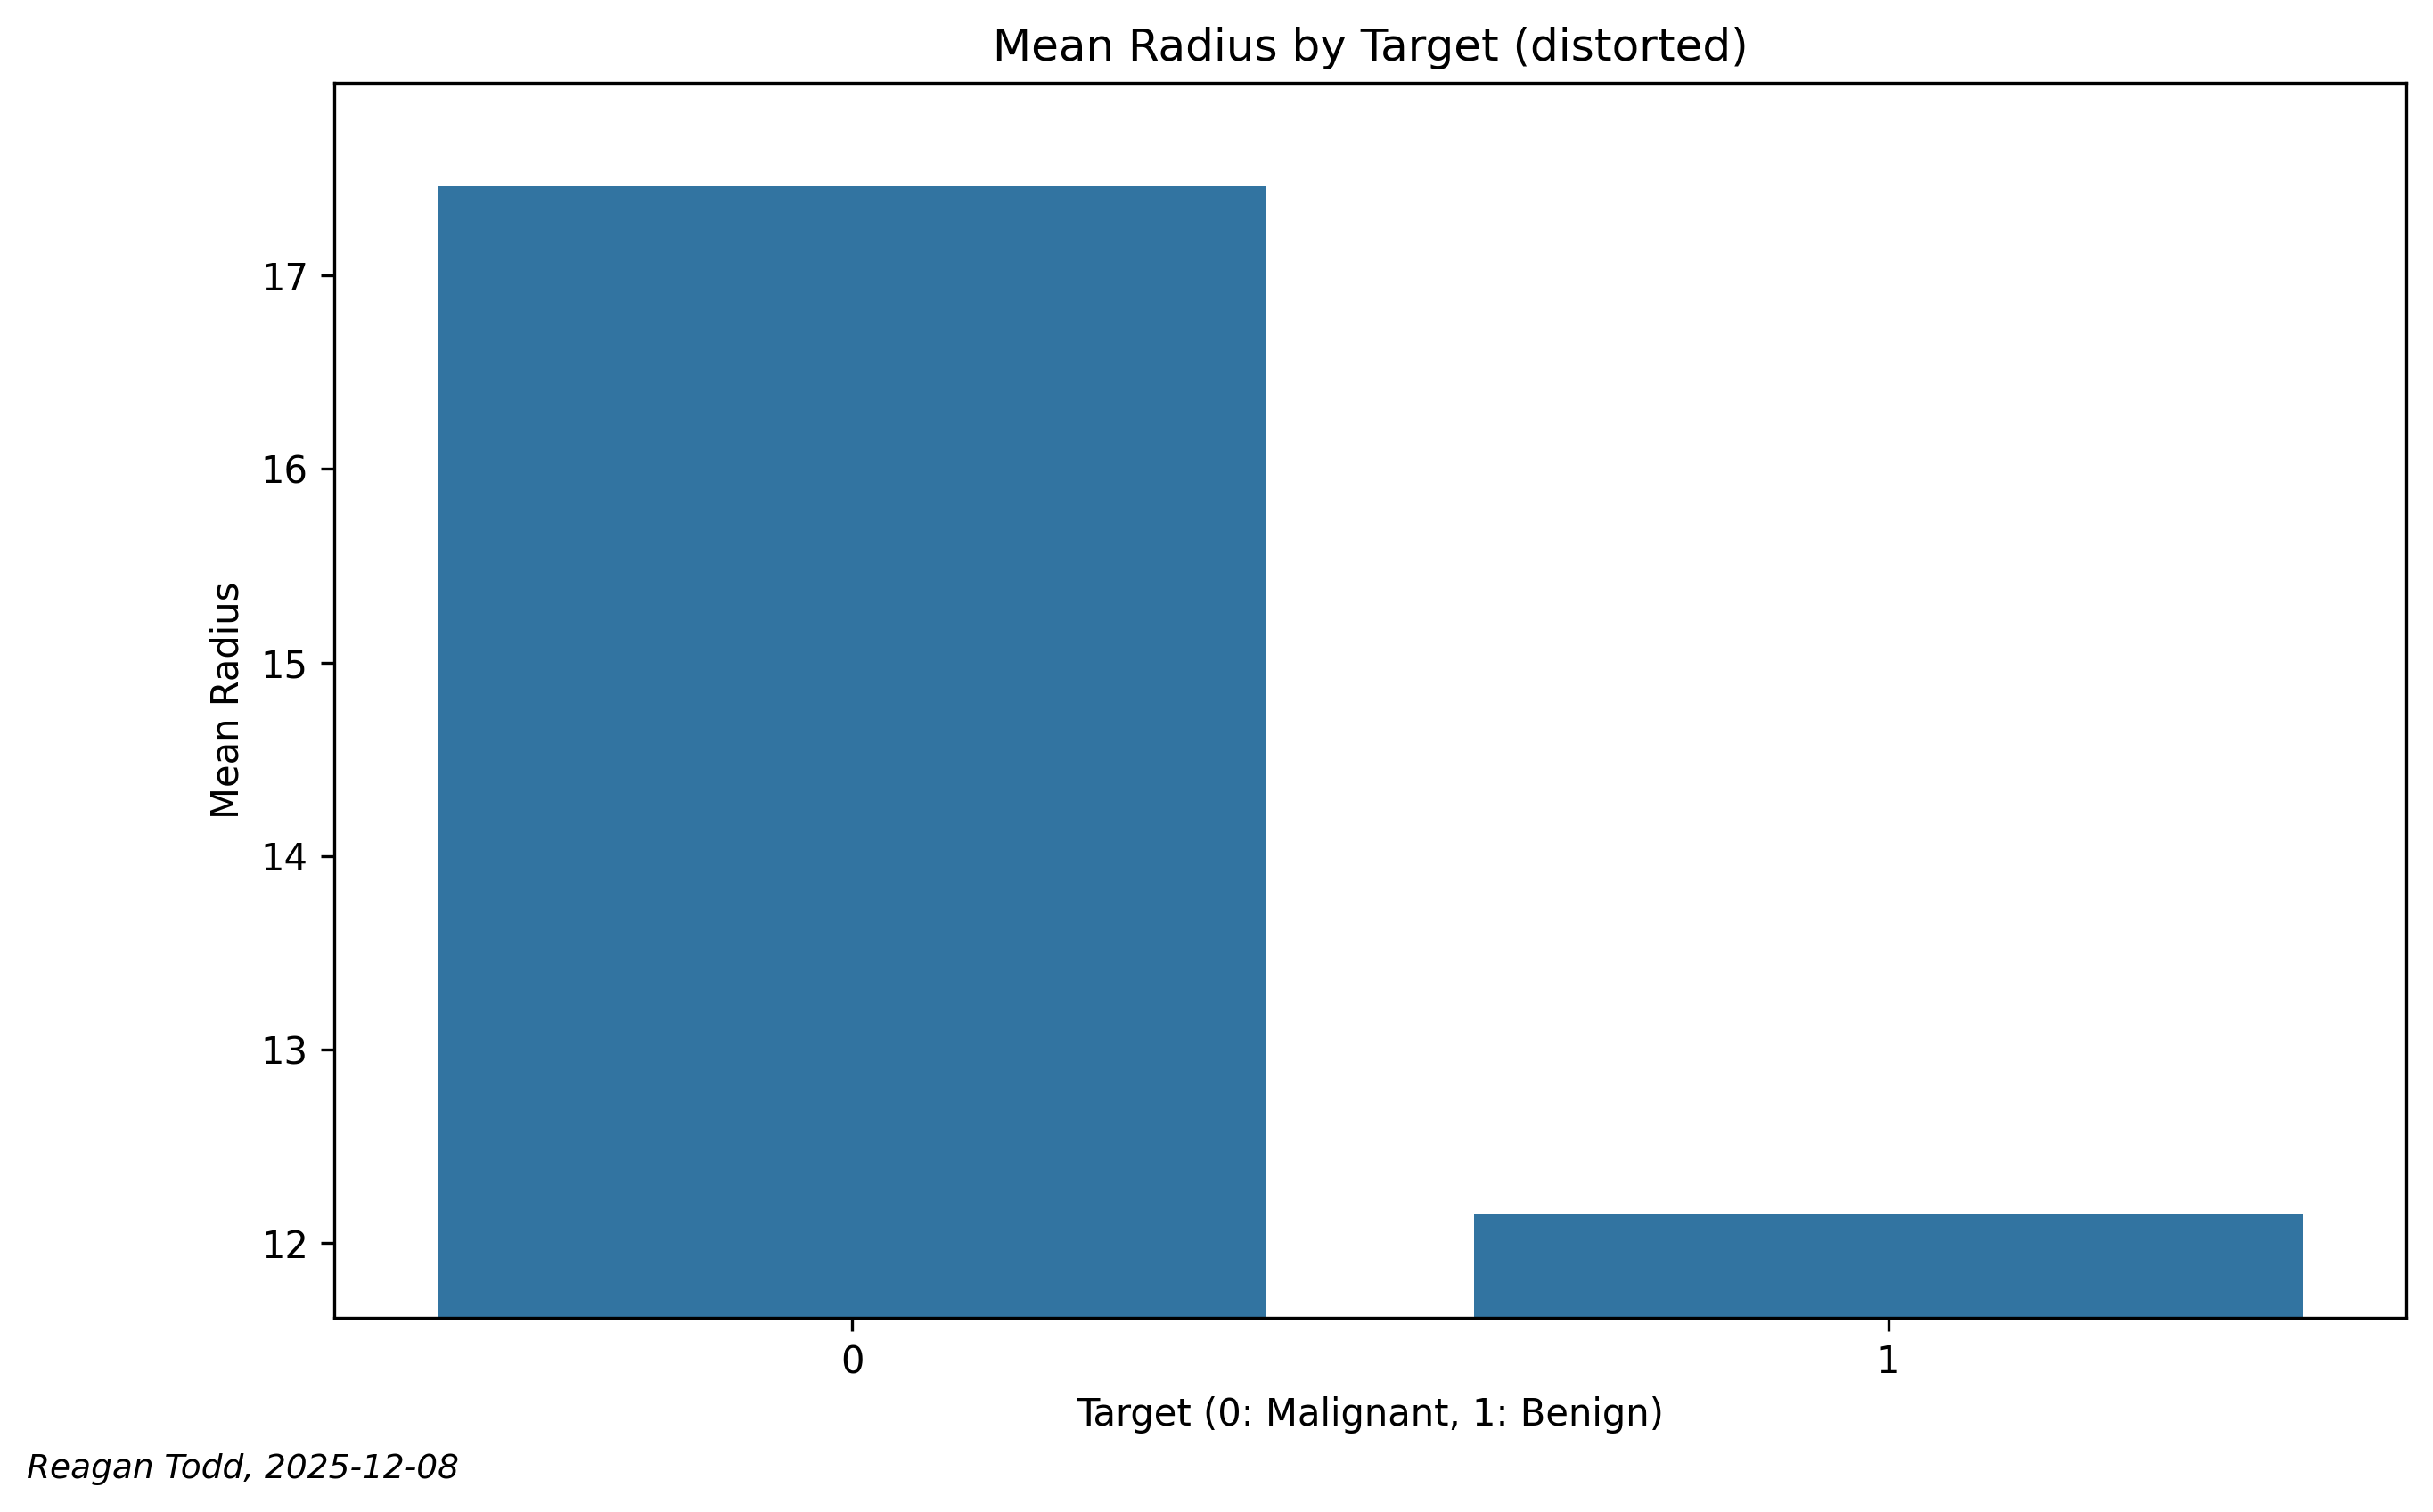

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

#mean radius of each class
mean_radii_by_target = df.groupby('target')['mean radius'].mean().reset_index()

#barchart
plt.figure(figsize=(10,6), dpi=300)
sns.barplot(x='target', y='mean radius', data=mean_radii_by_target)

min_val = mean_radii_by_target['mean radius'].min()
max_val = mean_radii_by_target['mean radius'].max()

#making distorted
y_start = min_val - (max_val - min_val) * 0.1
y_end = max_val + (max_val - min_val) * 0.1

plt.ylim(y_start, y_end)

plt.title('Mean Radius by Target (distorted)')
plt.xlabel('Target (0: Malignant, 1: Benign)')
plt.ylabel('Mean Radius')
plt.figtext(0.01, 0.01, "Reagan Todd, 2025-12-08", ha='left', fontsize=9, style="italic")
plt.show()

If not paying attention to the y-axis, it looks like malignant tumors have a much larger recorded radius compared to those who have benign tumors.

By starting at a radius of 12mm, which is nearly the maximum for benign tumors, it gives the illusion that they are vastly smaller in size, but in reality they only differ by about 5mm, which is about half of a pea. The exaggeration by starting at 12 make the viewer notice a larger difference between the mean radius.

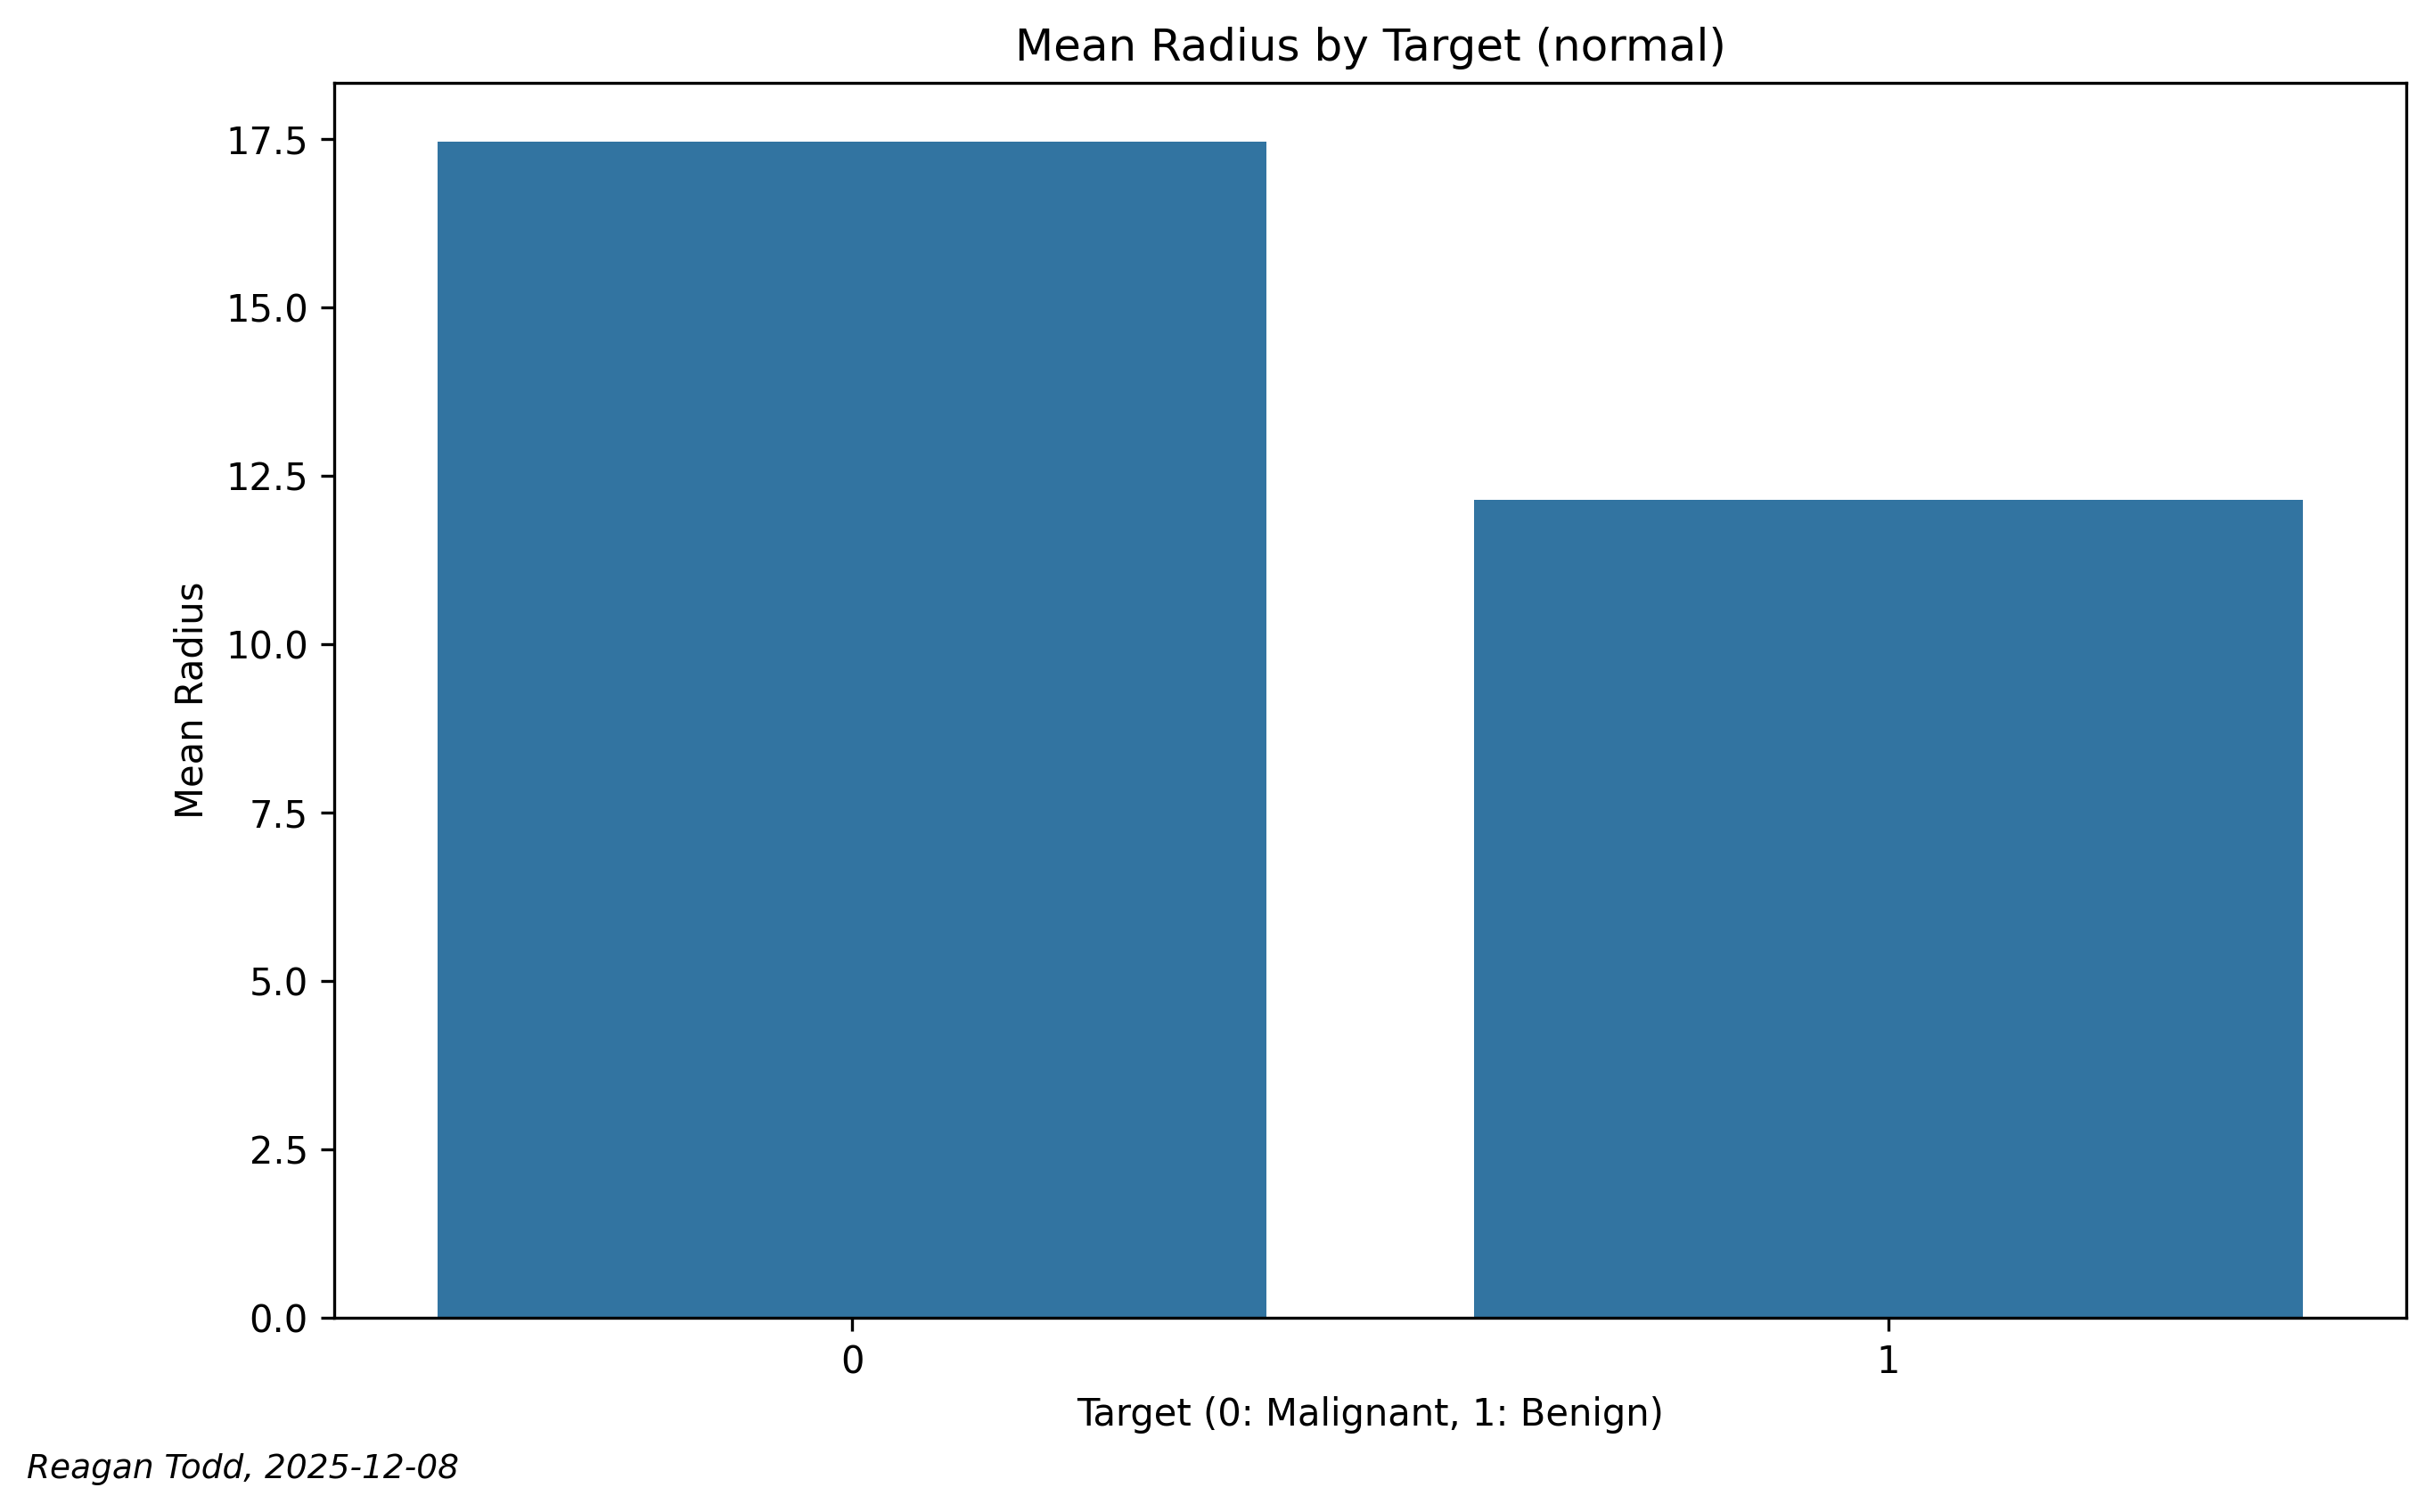

In [6]:
#barchart
plt.figure(figsize=(10,6), dpi=300)
sns.barplot(x='target', y='mean radius', data=mean_radii_by_target)

min_val = mean_radii_by_target['mean radius'].min()
max_val = mean_radii_by_target['mean radius'].max()

plt.title('Mean Radius by Target (normal)')
plt.xlabel('Target (0: Malignant, 1: Benign)')
plt.ylabel('Mean Radius')
plt.figtext(0.01, 0.01, "Reagan Todd, 2025-12-08", ha='left', fontsize=9, style="italic")
plt.show()

All that was changed between the distored bar chart and normal bar chart was starting the y-axis at 0 rather than just above the maximum for benign tumors. While malignant tumors are still larger (max around 17.4mm) it appears visually to be more similar in size to benign (max 12.3mm).

The difference is the same ~5mm, but having the y-axis start at 0, visually the difference does not look as drastic as it did in the distorted image. This would be suitable to submit whereas the first (distored) graph would misinterpret findings for viewers who are just glancing.

# Part B

In [7]:
#finding variable with the greatest variance
description_df = df.describe()
filtered_description = description_df.loc[:, description_df.loc['std'] > 400]
print(filtered_description)

#selecting the 'worst area' column as a series
worst_area_data = df['worst area']

        worst area
count   569.000000
mean    880.583128
std     569.356993
min     185.200000
25%     515.300000
50%     686.500000
75%    1084.000000
max    4254.000000


In [8]:
#sampling without replacement
sample_sizes = [30, 60, 120, 240]

for size in sample_sizes:
    sample = worst_area_data.sample(n=size, random_state=3809056, replace=False)

    sample_mean = sample.mean()
    sample_std = sample.std()
    standard_error = sample_std / (size**0.5)

    print("--Sampling without replacement--")
    print(f"Sample size: {size}")
    print(f"  Sample Mean: {sample_mean:.2f}")
    print(f"  Standard Error: {standard_error:.2f}")
    print("---------------------------------")


#sampling with replacement
sample_sizes = [30, 60, 120, 240]

for size in sample_sizes:
    sample = worst_area_data.sample(n=size, random_state=3809056, replace=True)

    sample_mean = sample.mean()
    sample_std = sample.std()
    standard_error = sample_std / (size**0.5)

    print("--Sampling with replacement--")
    print(f"Sample size: {size}")
    print(f"  Sample Mean: {sample_mean:.2f}")
    print(f"  Standard Error: {standard_error:.2f}")
    print("---------------------------------")

--Sampling without replacement--
Sample size: 30
  Sample Mean: 769.87
  Standard Error: 74.12
---------------------------------
--Sampling without replacement--
Sample size: 60
  Sample Mean: 834.92
  Standard Error: 68.05
---------------------------------
--Sampling without replacement--
Sample size: 120
  Sample Mean: 843.33
  Standard Error: 47.58
---------------------------------
--Sampling without replacement--
Sample size: 240
  Sample Mean: 854.52
  Standard Error: 35.05
---------------------------------
--Sampling with replacement--
Sample size: 30
  Sample Mean: 1050.77
  Standard Error: 153.40
---------------------------------
--Sampling with replacement--
Sample size: 60
  Sample Mean: 913.19
  Standard Error: 88.35
---------------------------------
--Sampling with replacement--
Sample size: 120
  Sample Mean: 905.73
  Standard Error: 56.51
---------------------------------
--Sampling with replacement--
Sample size: 240
  Sample Mean: 901.37
  Standard Error: 40.54
--------

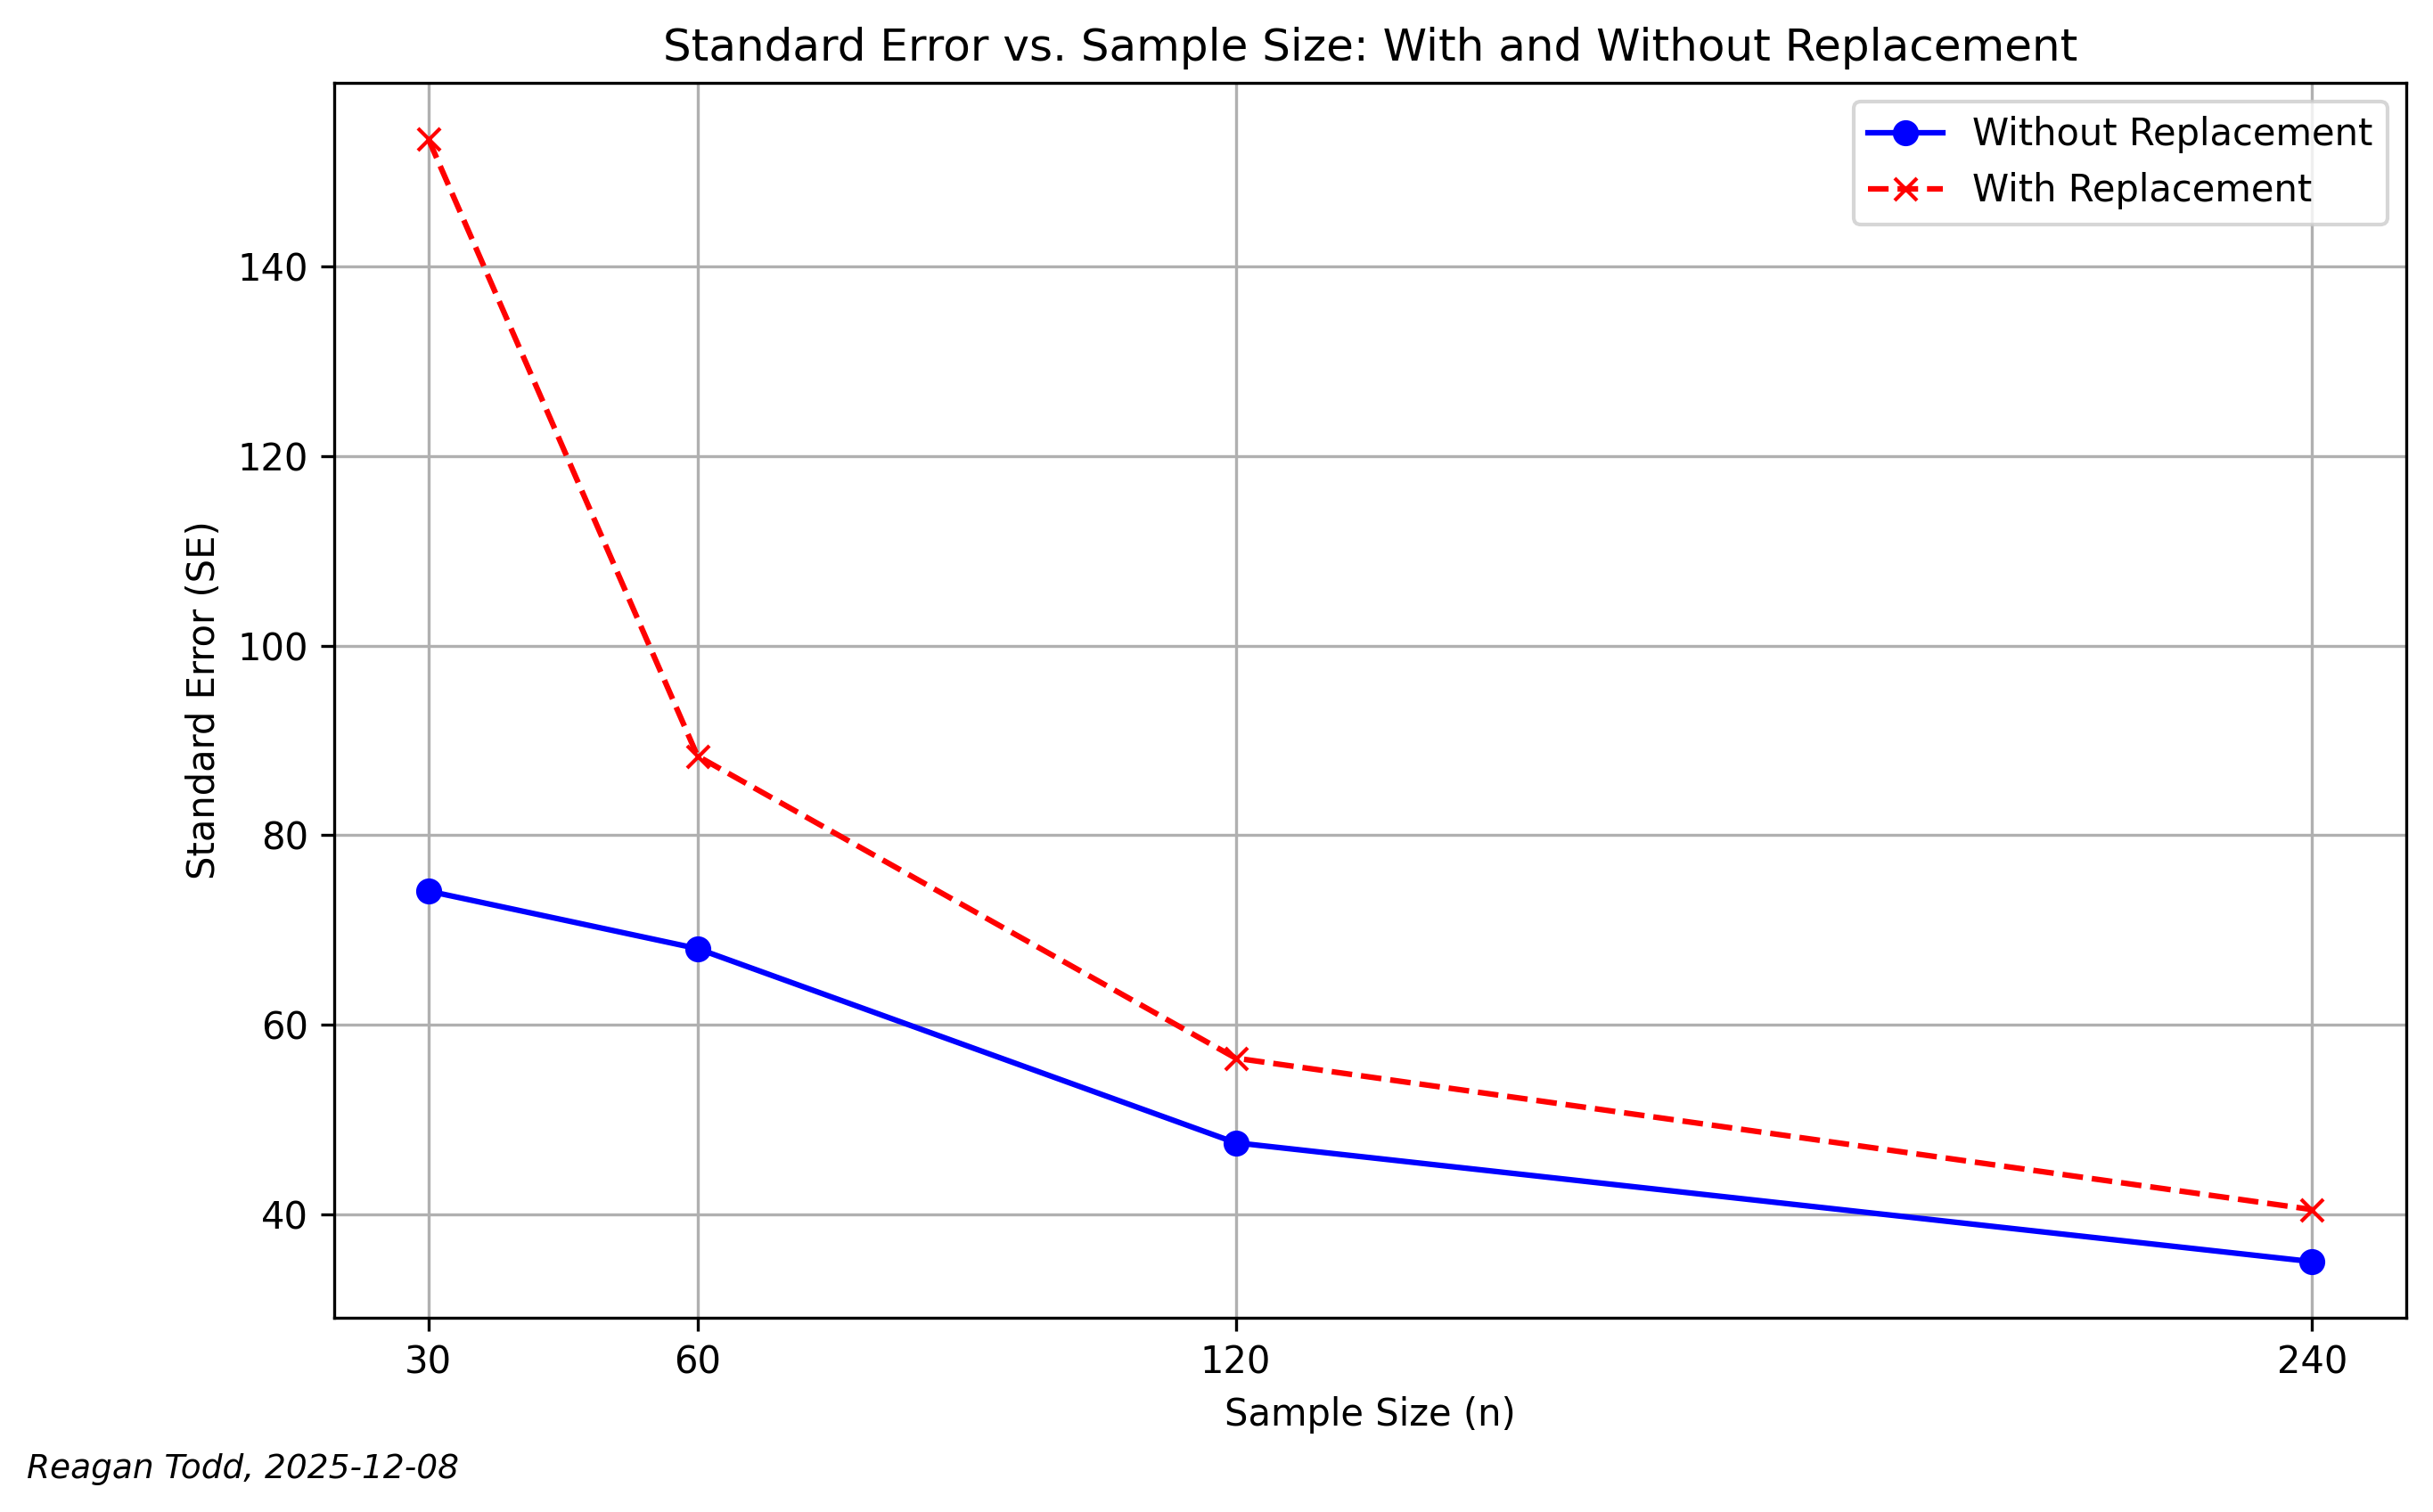

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

#ensure the data from above is available
if 'worst_area_data' not in locals():
    worst_area_data = df['worst area']

sample_sizes = [30, 60, 120, 240]

#recalculating for without replacement for graphing
without_replacement_ses = []
N = len(worst_area_data)
for size in sample_sizes:
    sample = worst_area_data.sample(n=size, random_state=3809056, replace=False)
    sample_std = sample.std()
    se_without_replacement = (sample_std / (size**0.5))
    without_replacement_ses.append(se_without_replacement)

#recalculating for with replacement for graphing
with_replacement_ses = []
for size in sample_sizes:
    sample = worst_area_data.sample(n=size, random_state=3809056, replace=True)
    sample_std = sample.std()
    se_with_replacement = sample_std / (size**0.5)
    with_replacement_ses.append(se_with_replacement)

#plotting single line graph
plt.figure(figsize=(10,6), dpi=300)
plt.plot(sample_sizes, without_replacement_ses, marker='o', linestyle='-', color='blue', label='Without Replacement')
plt.plot(sample_sizes, with_replacement_ses, marker='x', linestyle='--', color='red', label='With Replacement')

plt.title('Standard Error vs. Sample Size: With and Without Replacement')
plt.xlabel('Sample Size (n)')
plt.ylabel('Standard Error (SE)')
plt.grid(True)
plt.xticks(sample_sizes)
plt.legend()
plt.figtext(0.01, 0.01, "Reagan Todd, 2025-12-08", ha='left', fontsize=9, style="italic")
plt.show()

The standard error for sampling without replacement starts lower (74mm) and decreases at a slower rate as the sample size (n) increases. As proven, the standard error decreases as the sample size increases. When the sample size is 240, the standard error is 35mm.

Comparatively, the standard error for sampling with replacement for the Worst Area varaible starts very high at 153mm and decreases faster until it reaches 41mm (n=240). It is also seen here at as sample size increases, the standard error decreases.

This is due to our sample without replacement getting new/unique values for each draw it performs (finite population) whereas with replacement can select the same measure multiple times (inifinite population), decreasing the variance. Without replicates allows for unique and true error due to only selecting a value once. I did not add the FPC into my code, but the finite population structure offers more variance and treats each observation as a unqiue, one time draw.


In [10]:
#bootstrap
bootstrap_B = 800
n = len(worst_area_data)

bootstrap_means = []

#bootstrap loop
for _ in range(bootstrap_B):
    sample = worst_area_data.sample(n=n, random_state=None, replace=True)
      #random must be none here or else all replicates would be the same
    bootstrap_means.append(sample.mean())

bootstrap_means = np.array(bootstrap_means)

#95% CI (percentile method)
lower = np.percentile(bootstrap_means, 2.5)
upper = np.percentile(bootstrap_means, 97.5)
bootstrap_width = upper - lower

print(f"Bootstrap 95% CI (percentile): [{lower:.2f}, {upper:.2f}]")
print(f"Bootstrap CI width: {bootstrap_width:.2f}")

#theorhetical CI based on SE
mean_feature = worst_area_data.mean()
se_feature = worst_area_data.std(ddof=1) / np.sqrt(n)
theoretical_lower = mean_feature - 1.96 * se_feature
theoretical_upper = mean_feature + 1.96 * se_feature
theoretical_width = theoretical_upper - theoretical_lower

print(f"Theoretical 95% CI: [{theoretical_lower:.2f}, {theoretical_upper:.2f}]")
print(f"Theoretical CI width: {theoretical_width:.2f}")

#comparison
print(f"\nComparison:")
print(f"Bootstrap CI width: {bootstrap_width:.2f}")
print(f"Theoretical CI width: {theoretical_width:.2f}")

Bootstrap 95% CI (percentile): [834.58, 927.70]
Bootstrap CI width: 93.12
Theoretical 95% CI: [833.80, 927.37]
Theoretical CI width: 93.57

Comparison:
Bootstrap CI width: 93.12
Theoretical CI width: 93.57


The calculated CI [833.8, 927.4] based upon the datas SE and the CI [834.6, 927.7] from the bootstrap are very similar. This close similarity shows that our bootstrap performed well at predicting the population and proves a good estimation of sample mean while assuming a normal distribution for the Worst Area variable. The width, or range for the CI being within .5 of each CI also shows very similar results.

In [11]:
#outliers
from scipy import stats

#copy feature
feature = worst_area_data.copy()
n = len(feature)

#inject outliers
np.random.seed(3809056)
n_outliers = max(1, int(0.01 * n)) #1% of outliers
sigma = feature.std(ddof=1)
outlier_indices = np.random.choice(feature.index, n_outliers, replace=False)
feature.loc[outlier_indices] += 8 * sigma #8std

#mean and CI before outlier removal
mean_before = feature.mean()
se_before = feature.std(ddof=1) / np.sqrt(n)
ci_before = (mean_before - 1.96 * se_before, mean_before + 1.96 * se_before)

print("Before outlier removal:")
print(f"Mean: {mean_before:.2f}")
print(f"95% CI: [{ci_before[0]:.2f}, {ci_before[1]:.2f}]\n")

#using z-score to remove outliers
z_scores = np.abs(stats.zscore(feature))
clean_feature = feature[z_scores <= 3]

#mean and CI after outlier removal
mean_after = clean_feature.mean()
se_after = clean_feature.std(ddof=1) / np.sqrt(len(clean_feature))
ci_after = (mean_after - 1.96 * se_after, mean_after + 1.96 * se_after)

print("After outlier removal:")
print(f"Mean: {mean_after:.2f}")
print(f"95% CI: [{ci_after[0]:.2f}, {ci_after[1]:.2f}]\n")

mean_original = worst_area_data.mean()
std_original = worst_area_data.std(ddof=1)
se_original = std_original / np.sqrt(n)
ci_original = (mean_original - 1.96 * se_original, mean_original + 1.96 * se_original)

print("Original mean and 95% CI:")
print(f"Original Mean: {mean_original:.2f}")
print(f"Original CI: {ci_original[0]:.2f}, {ci_original[1]:.2f}\n")

Before outlier removal:
Mean: 920.61
95% CI: [862.60, 978.62]

After outlier removal:
Mean: 858.30
95% CI: [815.46, 901.15]

Original mean and 95% CI:
Original Mean: 880.58
Original CI: 833.80, 927.37



Before the outlier removal, our mean was 920.6 with a CI of [862.6, 978.6] and after our mean was 858.3 with a CI of [815.5, 901.2]. Based upon the results from bootstrapping and the theorhetical CI, the injected outliers increased our CI and the removal decreased it drastically.

This could also be explained by the z-score handling of extreme outliers overselected the large values and decreased our overall mean and CI.

Each of the CI include the true mean of 880.6 and are near the original CI of [833.8, 927.4]. Bootstrapping and calculated allow for a better approximation and handling compared to the manipulation and intertion of outliers.

# Part C

8-Fold Cross-Validation Results (Train)
CV Accuracy: 0.960 ± 0.020
CV ROC-AUC:  0.991 ± 0.009
Test Set Performance
Confusion Matrix:
[[ 54  10]
 [  3 104]]
Accuracy:    0.924
Sensitivity: 0.972
Specificity: 0.844
ROC-AUC:     0.990


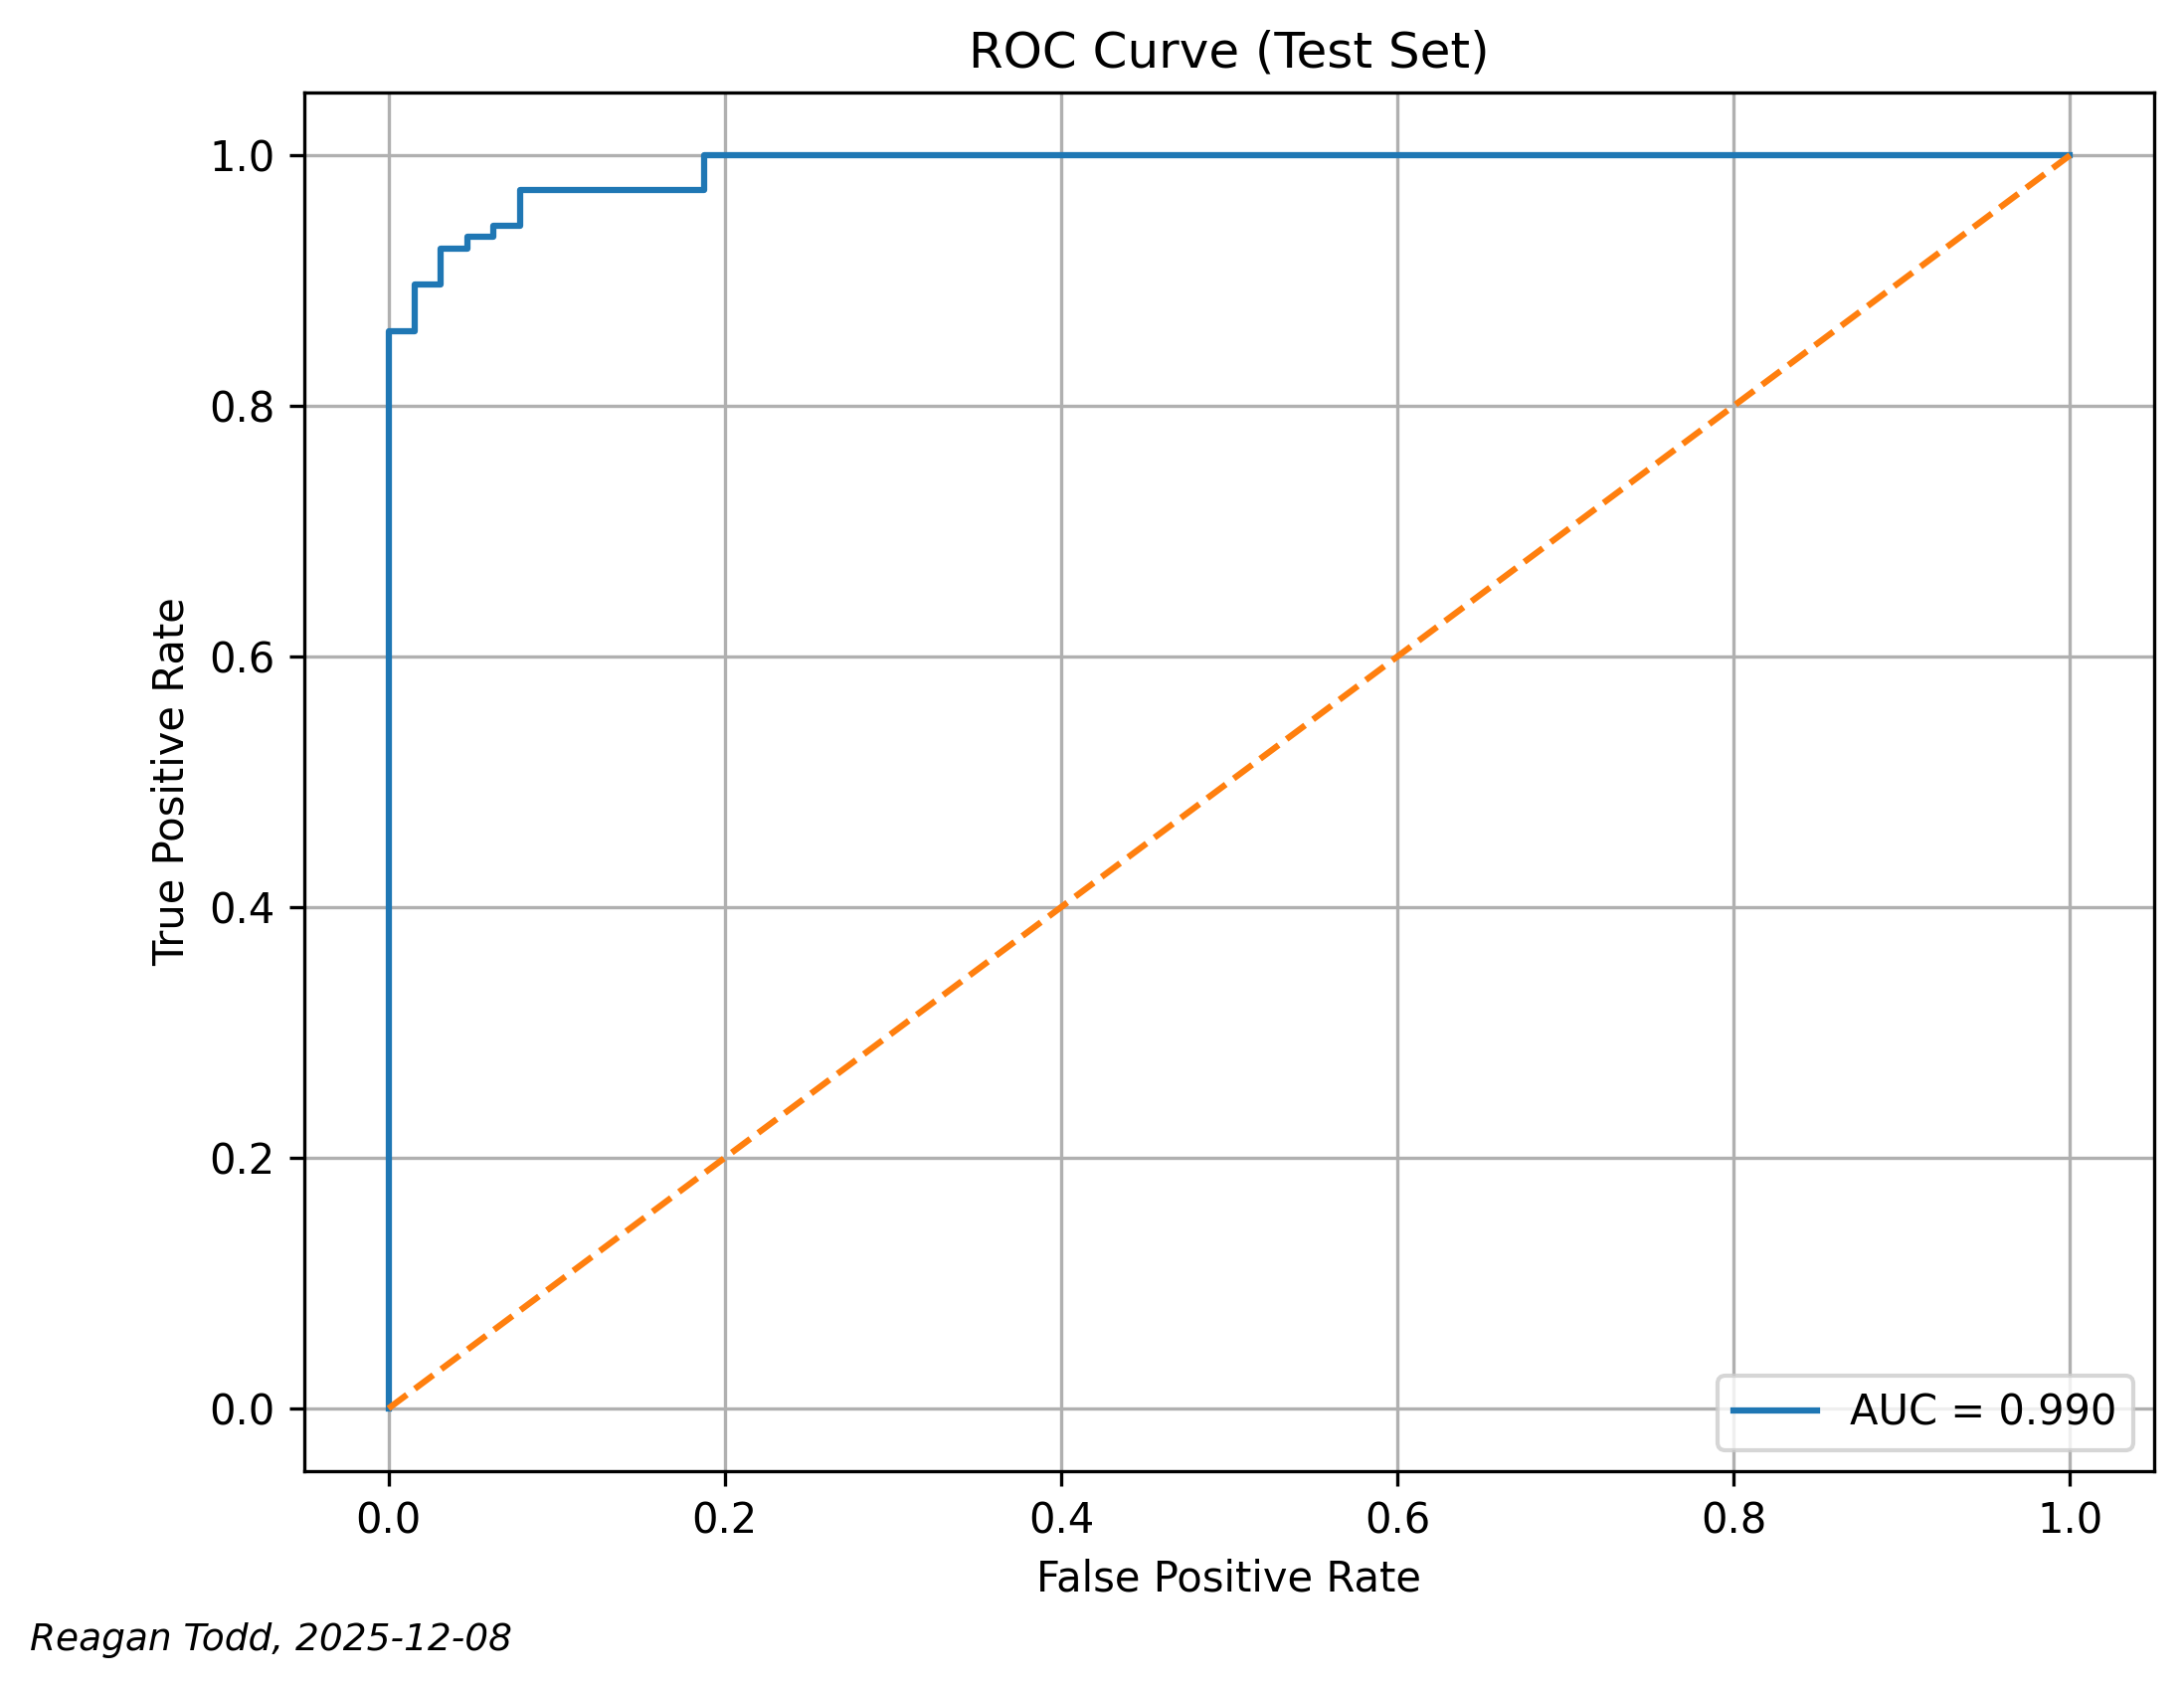

In [12]:
#supervised
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    recall_score,
    roc_auc_score,
    roc_curve)
import matplotlib.pyplot as plt

#df
X = df.drop('target', axis=1)
y = df['target']   # 0 = malignant, 1 = benign

#test/train split into 70/30
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.30,
    stratify=y,
    random_state=3809056
)


# 2.train with regularization
log_reg = LogisticRegression(max_iter=5000, solver='lbfgs')

log_reg.fit(X_train, y_train)


#8 fold cross on training

cv = StratifiedKFold(n_splits=8, shuffle=True, random_state=3809056)

cv_accuracy = cross_val_score(log_reg, X_train, y_train, cv=cv, scoring='accuracy')
cv_auc = cross_val_score(log_reg, X_train, y_train, cv=cv, scoring='roc_auc')

print("8-Fold Cross-Validation Results (Train)")
print(f"CV Accuracy: {cv_accuracy.mean():.3f} ± {cv_accuracy.std():.3f}")
print(f"CV ROC-AUC:  {cv_auc.mean():.3f} ± {cv_auc.std():.3f}")

#test eval
y_pred = log_reg.predict(X_test)
y_prob = log_reg.predict_proba(X_test)[:, 1]

cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

accuracy = accuracy_score(y_test, y_pred)
sensitivity = recall_score(y_test, y_pred)      # TPR
specificity = tn / (tn + fp)                    # TNR
test_auc = roc_auc_score(y_test, y_prob)

print("Test Set Performance")
print("Confusion Matrix:")
print(cm)
print(f"Accuracy:    {accuracy:.3f}")
print(f"Sensitivity: {sensitivity:.3f}")
print(f"Specificity: {specificity:.3f}")
print(f"ROC-AUC:     {test_auc:.3f}")

#roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure(figsize=(8, 6), dpi=300)
plt.plot(fpr, tpr, label=f"AUC = {test_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Test Set)")
plt.legend()
plt.grid(True)
plt.figtext(0.01, 0.01, "Reagan Todd, 2025-12-08", ha='left', fontsize=9, style="italic")
plt.show()

A cross validiated accuracy of 0.96 means that the model is able to correctly identify malignant vs benign tumors 96% of the time with a small deviation of 0.02. The ROC-AUC of 99.1% also shows excelent evidence that our model is able to distinguish the two tumor types.

From the confusion matrix, there is an accuracy of 92%, which is lower than the CV, but still very well. There were only 3 false negatives (missing of malignant tumors). The recall of positive, or sensitivity is 97.2% meaning that the model is good a predicting benign tumors. The model recognizes 84% of malignant cases, meaning the specificity is lower, resulting in benign tumors being marked as malignant. While good for being overly cautious, it could cause panic.

Having a threshold could be useful, but when it comes to breast cancer and terms of benign vs malignant tumors, I would rather be overly cautious like this model rather than having the possibility of making an error with a threshold.

In [13]:
#unsupervised
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

#loading data
X = df.drop('target', axis=1)
y = df['target']   # 0 = malignant, 1 = benign

#standardizing numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#kmeans, k=2
kmeans = KMeans(n_clusters=2, n_init=20, random_state=3809056)
cluster_labels = kmeans.fit_predict(X_scaled)

#ARI
ari = adjusted_rand_score(y, cluster_labels)
print(f"Adjusted Rand Index (ARI): {ari:.3f}")

Adjusted Rand Index (ARI): 0.671


An adjusted rand index (ARI) of 0.671 as shown above shows a moderately good alignment of seperation without labels. If it were to have perfect alignment of seperation of benign/malignant then our ARI would have been closer to or equal to 1. It was able to seperate more than half the time, but in this case, the unsupervised learning did not perform as well as the supervised (log regression).  

# parametric/non-parametric/probablistic
Parametric Models

  Naïve Bayes (supervised): Assumes a parametric probability distribution for features (e.g., Gaussian).
  Uses Bayes’ theorem to compute class probabilities under the independence assumption.

  MLP/Artificial Neural Networks (ANN, supervised): Parametric because the architecture contains a fixed number of weights/biases.
  Learning adjusts these parameters to minimize loss.

  Logistic regression (supervised):
  Assumes a fixed functional form: the log-odds of the outcome is a linear combination of the input features.
  Outputs class probabilities via the sigmoid function

Non-Parametric Models

  K-Nearest Neighbors (KNN, supervised)
  Stores training data; no explicit model form. Predictions depend on distances to the nearest neighbors.

  Decision Trees (supervised)
  Splits data based on features without assuming a functional form.
  Tree complexity can grow with data unless pruned.

  Random Forest (supervised)
  Ensemble of non-parametric trees grown on bootstrapped samples.
  Uses feature subsampling to reduce correlation between trees.

Probabilistic Models

  Naïve Bayes (explicitly told in lecture, could have others based upon classificiation)
  Explicitly computes
  𝑃(𝑦∣𝑥)P(y∣x) using Bayes’ theorem.

  Logistic regression


# Part D

In [14]:
#KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score

#load data
X = df.drop('target', axis=1)
y = df['target']   # 0 = malignant, 1 = benign

#70/30 split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=3809056)

#standardize for KNN
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#KNN
knn_k = 3

knn = KNeighborsClassifier(n_neighbors=knn_k)
knn.fit(X_train_scaled, y_train)

y_pred_knn = knn.predict(X_test_scaled)

knn_acc = accuracy_score(y_test, y_pred_knn)
knn_bal_acc = balanced_accuracy_score(y_test, y_pred_knn)

print("KNN Results:")
print(f"Test Accuracy: {knn_acc:.3f}")
print(f"Balanced Accuracy: {knn_bal_acc:.3f}\n")


KNN Results:
Test Accuracy: 0.953
Balanced Accuracy: 0.941



In [15]:
#Decision Tree
tree_depth = 6

tree = DecisionTreeClassifier(max_depth=tree_depth, random_state=3809056)
tree.fit(X_train, y_train)

y_pred_tree = tree.predict(X_test)

tree_acc = accuracy_score(y_test, y_pred_tree)
tree_bal_acc = balanced_accuracy_score(y_test, y_pred_tree)

print("Decision Tree Results:")
print(f"Test Accuracy: {tree_acc:.3f}")
print(f"Balanced Accuracy: {tree_bal_acc:.3f}")


Decision Tree Results:
Test Accuracy: 0.942
Balanced Accuracy: 0.931


The KNN slightly outperformed the decision tree here.

KNN had a test accuracy of 95% and a balanced accuracy of 94% showing that it was able to accuratly use the 3 nearest neighbors to assign the class. A low k, such as 3, makes it very sensitive to local noise which can ultimately lead to low bias but high variance. That was not noticed here.

The decision tree had a test accuracy of 94% and a balanced accuracy of 93% showing that it was still able to accurately create a tree with a depth of 6 and give generalizable results. With a depth of 6, there is a chance for high bias and low variance. With increased depth, that bias can increase.

How each work: (taken from my final review sheet)
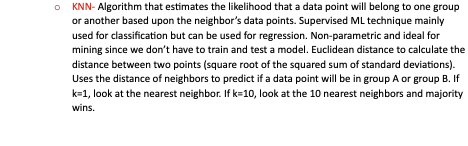
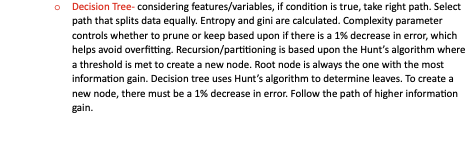

# Part E

N=100, Estimated p̂ = 0.670
N=1000, Estimated p̂ = 0.646
N=10000, Estimated p̂ = 0.649


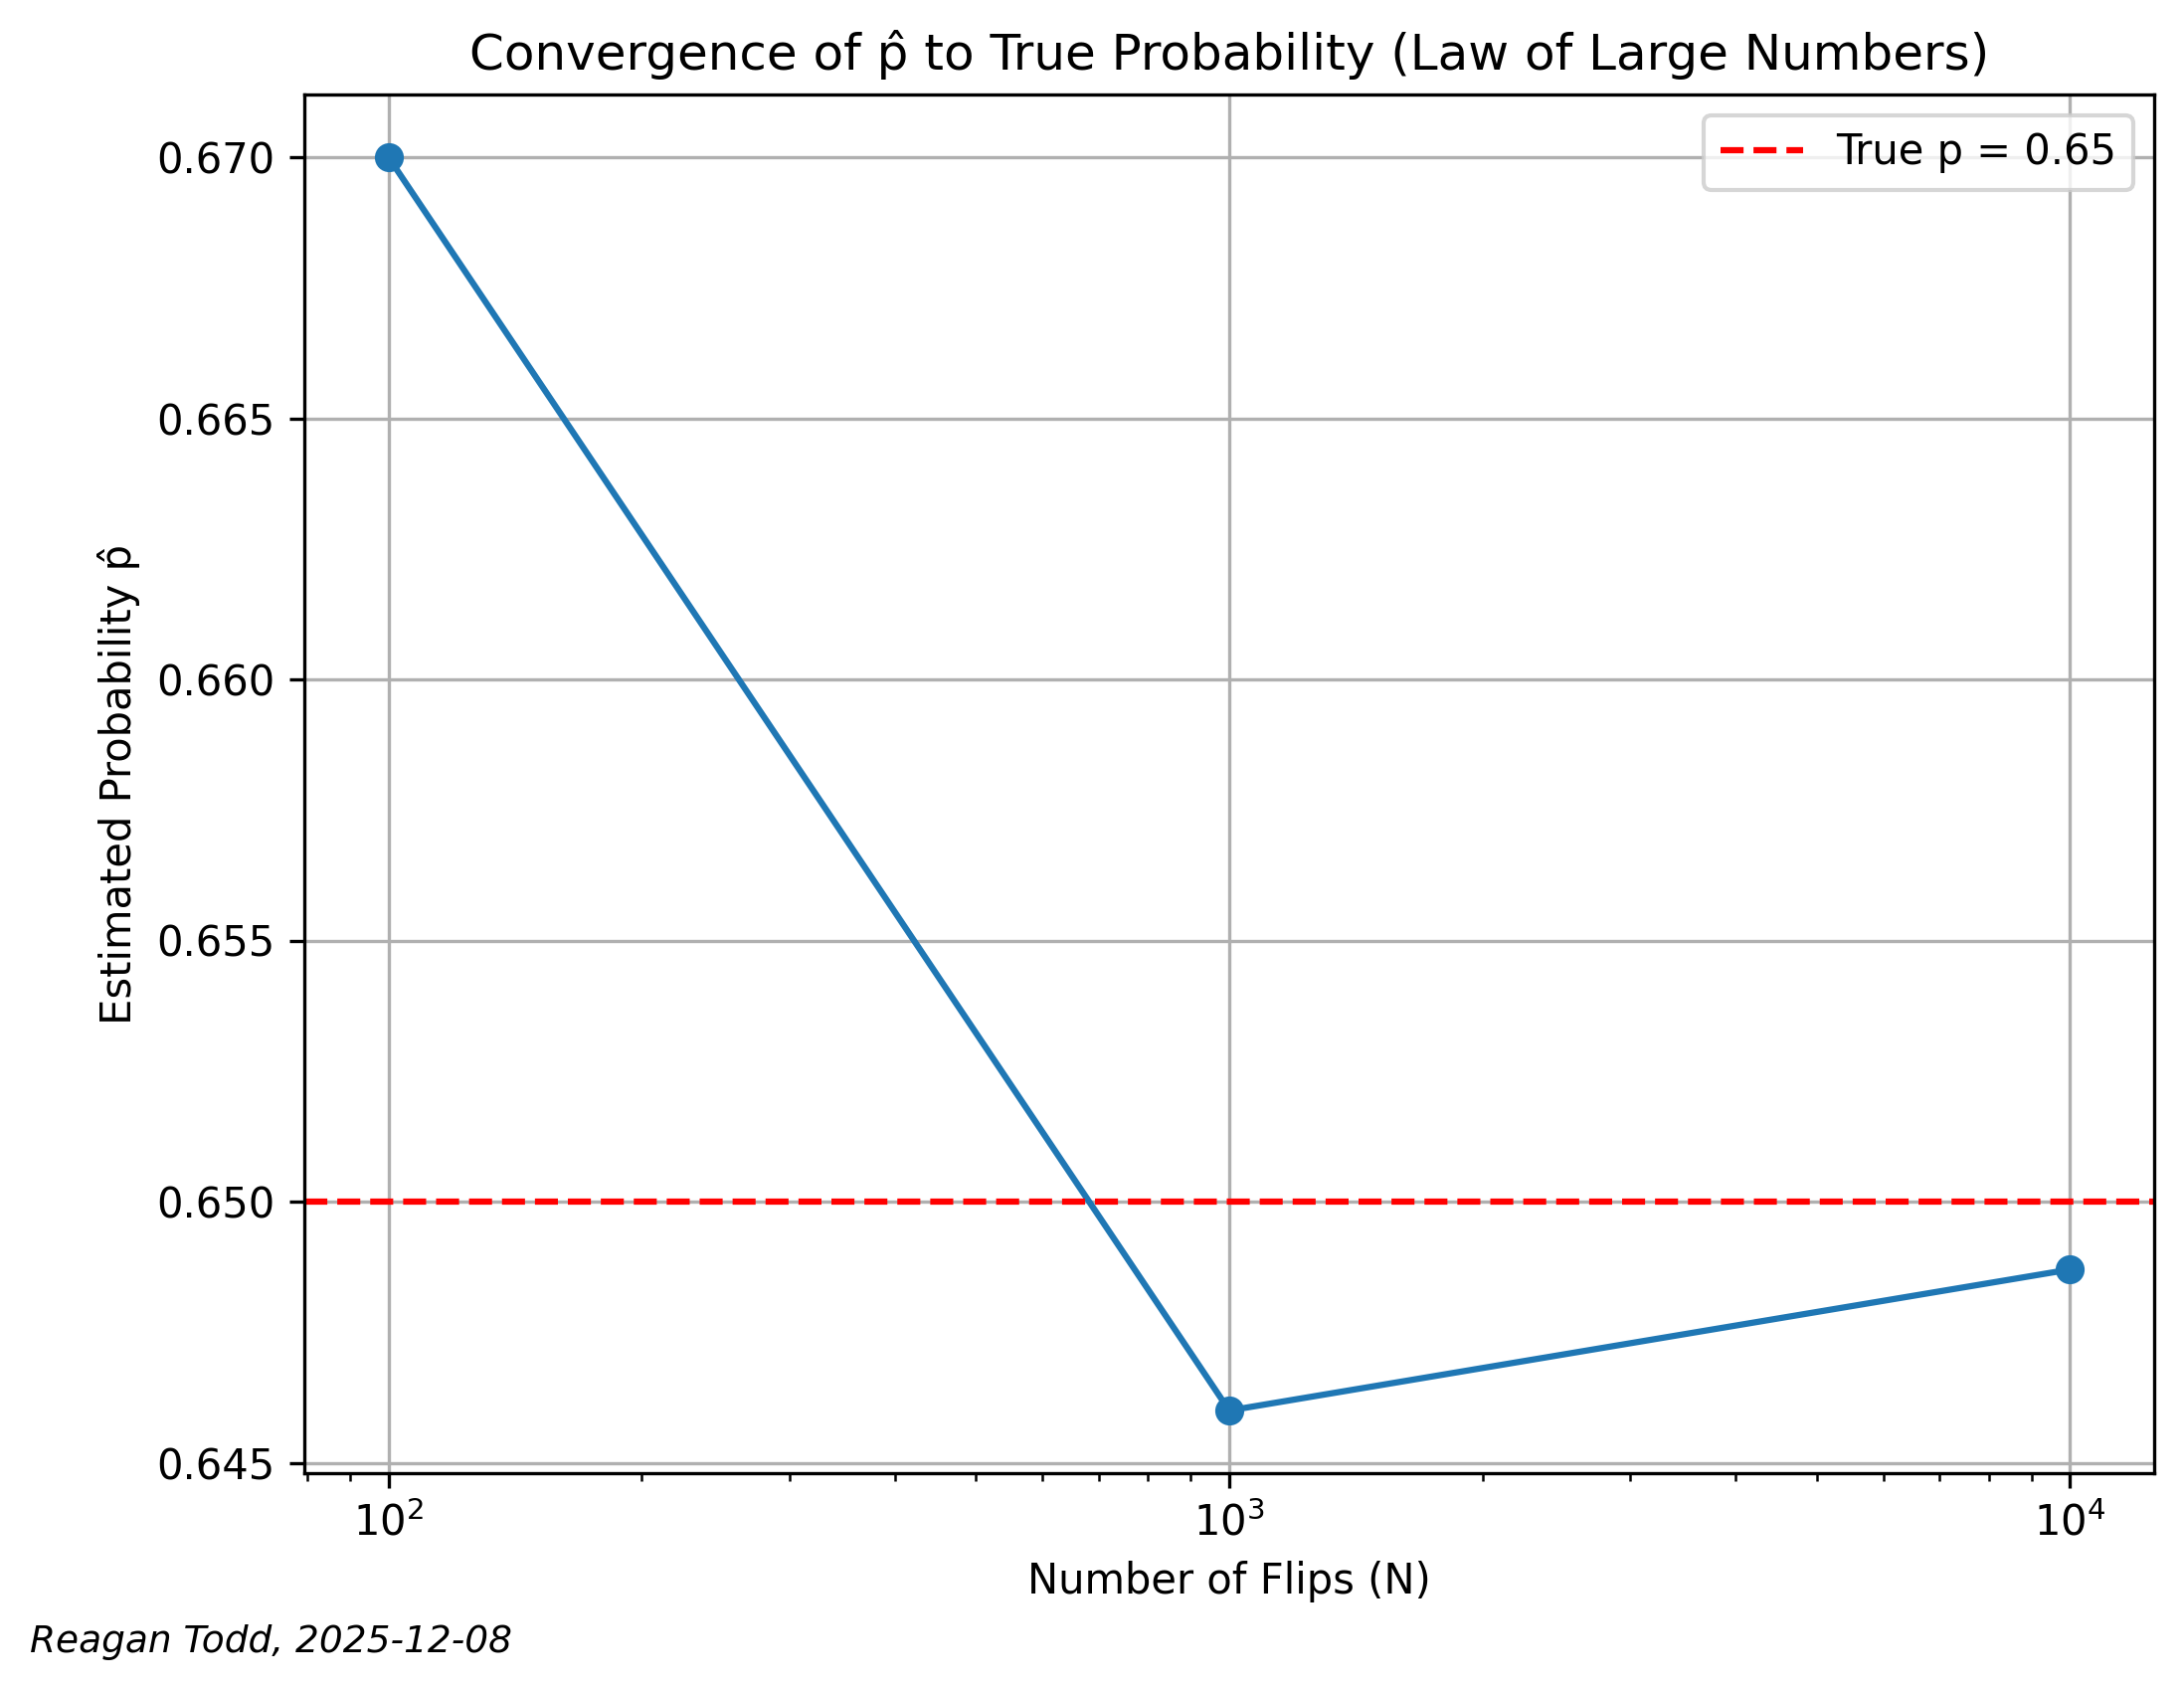

In [16]:
#simulation bias
sim_bias_p = 0.65
Ns = [100, 1000, 10000]
np.random.seed(3809056)

#store probabilities
p_hats = []

for N in Ns:
    flips = np.random.binomial(n=1, p=sim_bias_p, size=N)  # 1 = heads, 0 = tails
    p_hat = flips.mean()
    p_hats.append(p_hat)
    print(f"N={N}, Estimated p̂ = {p_hat:.3f}")

#plot p̂ vs N
plt.figure(figsize=(8,6), dpi=300)
plt.plot(Ns, p_hats, marker='o', linestyle='-')
plt.axhline(sim_bias_p, color='red', linestyle='--', label=f'True p = {sim_bias_p}')
plt.xscale('log')
plt.xlabel("Number of Flips (N)")
plt.ylabel("Estimated Probability p̂")
plt.title("Convergence of p̂ to True Probability (Law of Large Numbers)")
plt.legend()
plt.grid(True)
plt.figtext(0.01, 0.01, "Reagan Todd, 2025-12-08", ha='left', fontsize=9, style="italic")
plt.show()


THis is a perfect graphic illustrating the law of large numbers. As N flips increase, the sample mean gets closer to the expected mean probability. For example, when N=100, the probability was higher than the true prob of 0.67> 0.65. When N=10,000 the probability was 0.646, which is very close to the true probability of 0.65. This shows that as the trials increase, the randomization averages out.

# Part F

In [17]:
#regex
import re

text = """
Amy started on 2025-12-10. Her ID is roo-0001
Bob started on 2024-05-11. His ID is roo-0002 and his email is bob@umkc.edu
Carols email is carol@umkc.edu
Dave started on 2023-08-07 and his ID is roo-0004
Eve's student ID is roo-0005 and her email is eve@umkc.edu
Frank hasn't started at umkc yet
George loves his george@umkc.edu email and started 2010-01-20
Hannah has a student id of roo-0008
Isabel can be contacted at isabel@umkc.edu and has a student id of roo-0009
"""

#emails
emails = re.findall(r'\b[\w\.-]+@[\w\.-]+\.\w+\b', text)

#\b[\w\.-]+ explains that there can be any sort of character here, matches the word brackets to ensure full match
#@[\w\.-]+\.\w+\b shows that after the @ there can be any character match
#+ allows for any amount of character (one or more times)
#could also anchor "@umkc.edu" to the end since all of these are umkc emails

#enrollment dates (flexible format but could be simplifed)
dates = re.findall(r'\b\d{4}[-/]\d{2}[-/]\d{2}\b|\b\d{2}[-/]\d{2}[-/]\d{4}\b|\b\w{3,9} \d{1,2}, \d{4}\b', text)

#\b\d{4}[-/]\d{2}[-/]\d{2}\b this section forces a YYYY/-MM/-DD
#\b\d{2}[-/]\d{2}[-/]\d{4}\b specifies a MM/-DD/-YYYY format
#\b\w{3,9} \d{1,2}, \d{4}\b specifies word format of Month Day, YYYY
#the | in between here states it needs to find one of these.


#ID
ids = re.findall(r'\broo-\d+\b', text)

#/b opens the word boundary, the string starts with roo-
#followed by digits one or more times


print("Emails:", emails)
print("Ennrollment Dates:", dates)
print("IDs:", ids)

Emails: ['bob@umkc.edu', 'carol@umkc.edu', 'eve@umkc.edu', 'george@umkc.edu', 'isabel@umkc.edu']
Ennrollment Dates: ['2025-12-10', '2024-05-11', '2023-08-07', '2010-01-20']
IDs: ['roo-0001', 'roo-0002', 'roo-0004', 'roo-0005', 'roo-0008', 'roo-0009']


In [19]:
#NLP
#labeled corpus
corpus = [
    ("I loved this class, it was greatl!", "positive"),
    ("Absolutely fantastic teacher, very satisfied.", "positive"),
    ("The lectures were smooth and educational.", "positive"),
    ("I am thrilled with my grade!", "positive"),
    ("Highly recommend this course to everyone.", "positive"),
    ("Great materials, exceeded my expectations.", "positive"),

    ("I hated this class, it broke me quickly.", "negative"),
    ("Worst lectures, very disappointed.", "negative"),
    ("Worst class I have ever taken.", "negative"),
    ("Not worth my energy at all.", "negative"),
    ("Very unhappy with my grade.", "negative"),
    ("Extremely poor lessons, avoid this.", "negative")
]

texts, labels = zip(*corpus)

from sklearn.feature_extraction.text import TfidfVectorizer

#convert text to tf-idf
vectorizer = TfidfVectorizer(ngram_range=(1,3)) #bigram
X = vectorizer.fit_transform(texts)

#train logistic regression
model = LogisticRegression()
model.fit(X, labels)

#sample
sample_text = ["This class was great!"]
X_sample = vectorizer.transform(sample_text)

#prediction
prediction = model.predict(X_sample)
print("Predicted Sentiment:", prediction[0])

#non-zero tf-idf
feature_names = vectorizer.get_feature_names_out()
tfidf_df = pd.DataFrame(X_sample.toarray(), columns=feature_names)
tfidf_nonzero = tfidf_df.loc[:, (tfidf_df != 0).any()]
print("\nTF-IDF values for the sample sentence:\n", tfidf_nonzero)


Predicted Sentiment: positive

TF-IDF values for the sample sentence:
       class     great      this  this class       was
0  0.390368  0.514565  0.350386    0.441914  0.514565


The tf-idf values of 0.39 and 0.35 for class and this show a very low score, meaning they aren't very important since they occur in numerous lines.

This class having a tf-idf was seen more with positive sentiments so it has a greater weight, but still a fairly low tf-idf.

great and was have higher tf-idf scores showing they are more important and using the bi-gram can give context (specific to was) that is positive.

These are all fairly low tf-idf scores and would benefit more if we had a larger corpus or less frequent occurances. As the occurance of the word(s) increase in each document, the lower the tf-idf score gets. Much like discussed, the word "the" or "a" would have a very high TF (since it occurs very often) but a very low (0) idf since it is common and not unique amongst the various documents in our corpus.